In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization,Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam
from PIL import Image 
import numpy as np
import re
import os 
import glob 
import random
import logging
from tensorflow.keras import backend as K
import math
tf.get_logger().setLevel(logging.ERROR)

In [2]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape, n_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)
    c4, p4 = encoder_block(p3, 128)

    c5 = conv_block(p4, 256) #Bridge
    c6 = decoder_block(c5, c4, 128)
    c7 = decoder_block(c6, c3, 64)
    c8 = decoder_block(c7, c2, 32)
    c9 = decoder_block(c8, c1, 16)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(c9)
    model = Model(inputs, outputs, name="U-Net")
    return model

In [6]:
import matplotlib.pyplot as plt

def visualize(original, augmented, figure_size=(10,5)):
    fig = plt.figure(figsize=figure_size)
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

# Load model checkpoint 

In [23]:
checkpoint_path = "/app/seg/jaccard_coefficient_mode.h5"
model = build_unet(input_shape=(128,128,3), n_classes=1)
model.load_weights(checkpoint_path)

# Load img preprocess inference

In [ ]:
def prepare_input_img(img_path, img_w=128, img_h=128):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
    resize_img = tf.image.resize_with_pad(img, target_height=img_h, target_width=img_w, method='bilinear')
    input_img = tf.expand_dims(resize_img, axis=0)
    return input_img

(1, 128, 128, 3)


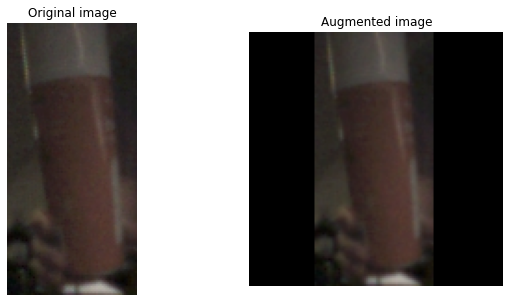

In [24]:
img_path = "/app/seg/data/images/test/9300633320775_1708733394893_2_1708733432295_9626189.jpg"
img = tf.io.read_file(img_path)
img = tf.image.decode_image(img, channels=3, dtype=tf.float32)
resize_img = tf.image.resize_with_pad(img, target_height=128, target_width=128, method='bilinear')
input_img = tf.expand_dims(resize_img, axis=0)
print(input_img.shape)
visualize(img, resize_img)

In [14]:
mask_path = "/app/seg/data/labels/test/9300633320775_1708733394893_2_1708733432295_9626189.png"
mask = tf.io.read_file(mask_path)
mask = tf.image.decode_image(mask, channels=1, dtype=tf.float32)
resize_mask = tf.image.resize_with_pad(mask, target_height=128, target_width=128, method='bilinear')

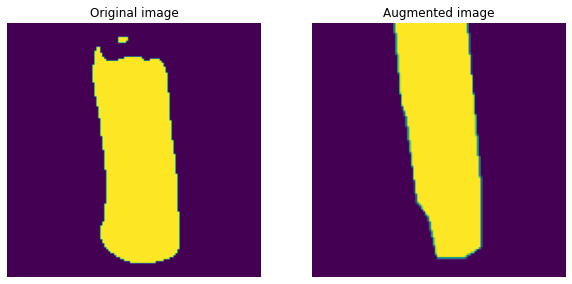

In [42]:
pred = model(input_img)
pred = tf.squeeze(pred)
conf_threshold = 0.5
pred = tf.where(pred > conf_threshold, 1., 0)
visualize(pred, resize_mask)

In [43]:
def apply_single_channel_mask(image, mask):
    mask_3_channels = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    masked_image = np.where(mask_3_channels, image, 0)
    return masked_image

In [44]:
def crop_masked_region(masked_image, mask):
    non_zero_indices = np.argwhere(mask)
    min_y, min_x = np.min(non_zero_indices, axis=0)
    max_y, max_x = np.max(non_zero_indices, axis=0)
    cropped_masked_image = masked_image[min_y:max_y+1, min_x:max_x+1]
    return cropped_masked_image

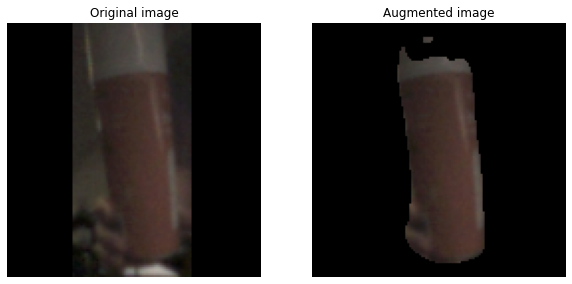

In [45]:
masked_img = apply_single_channel_mask(resize_img, pred)
visualize(resize_img, masked_img)

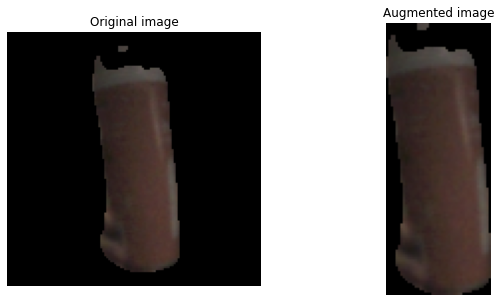

In [46]:
crop_img = crop_masked_region(masked_img, pred)
visualize(masked_img, crop_img)